In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as Fun
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
# try running the following code, if you see errors on Windows OS
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [3]:
import pandas as pd
import numpy as np

# File to Load (Remember to Change These)
file_to_load = "Data\Steel_industry_data.csv"

# Read Purchasing File and store into Pandas data frame
steel_csv = pd.read_csv(file_to_load)
steel_csv.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


In [4]:
yMax=max(steel_csv['Usage_kWh'])
yMin=min(steel_csv['Usage_kWh'])

In [5]:
steel_csv.Load_Type.replace(('Medium_Load', 'Light_Load', 'Maximum_Load'),(1, 0, 2), inplace=True)
#steel_csv.WeekStatus.replace(('Weekday', 'Weekend'),(1, 0), inplace=True)
steel_csv.Day_of_week.replace(('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'),(1, 2, 3, 4, 5, 6, 7), inplace=True)
steel_csv.head()
steel_y = steel_csv['Load_Type'].to_numpy()
steel_x = steel_csv[['Usage_kWh','Lagging_Current_Reactive.Power_kVarh','Leading_Current_Reactive_Power_kVarh','Day_of_week']].fillna(0).to_numpy()

In [6]:
cols=[x for i,x in enumerate(steel_csv.columns) if steel_csv.iat[0,i]=='Weekend']
steel_weekday=steel_csv.drop(cols,axis=1)
steel_weekday
#steel_y = steel_weekday['Usage_kWh'].to_numpy()
#steel_x = steel_weekday[['Usage_kWh','Lagging_Current_Reactive.Power_kVarh','Leading_Current_Reactive_Power_kVarh','Day_of_week']].fillna(0).to_numpy()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.00,0.0,73.21,100.00,900,Weekday,1,0
1,01/01/2018 00:30,4.00,4.46,0.00,0.0,66.77,100.00,1800,Weekday,1,0
2,01/01/2018 00:45,3.24,3.28,0.00,0.0,70.28,100.00,2700,Weekday,1,0
3,01/01/2018 01:00,3.31,3.56,0.00,0.0,68.09,100.00,3600,Weekday,1,0
4,01/01/2018 01:15,3.82,4.50,0.00,0.0,64.72,100.00,4500,Weekday,1,0
...,...,...,...,...,...,...,...,...,...,...,...
35035,31/12/2018 23:00,3.85,4.86,0.00,0.0,62.10,100.00,82800,Weekday,1,0
35036,31/12/2018 23:15,3.74,3.74,0.00,0.0,70.71,100.00,83700,Weekday,1,0
35037,31/12/2018 23:30,3.78,3.17,0.07,0.0,76.62,99.98,84600,Weekday,1,0
35038,31/12/2018 23:45,3.78,3.06,0.11,0.0,77.72,99.96,85500,Weekday,1,0


In [7]:
steel_csv=steel_csv.drop(['NSM','WeekStatus','Day_of_week'],axis=1)

In [8]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
mms.fit(steel_csv.iloc[:-800][['Usage_kWh','Lagging_Current_Reactive.Power_kVarh','Leading_Current_Reactive_Power_kVarh','CO2(tCO2)','Lagging_Current_Power_Factor','Leading_Current_Power_Factor','Load_Type']])
steel_csv[['Usage_kWh','Lagging_Current_Reactive.Power_kVarh','Leading_Current_Reactive_Power_kVarh','CO2(tCO2)','Lagging_Current_Power_Factor','Leading_Current_Power_Factor','Load_Type']] = mms.transform(steel_csv[['Usage_kWh','Lagging_Current_Reactive.Power_kVarh','Leading_Current_Reactive_Power_kVarh','CO2(tCO2)','Lagging_Current_Power_Factor','Leading_Current_Power_Factor','Load_Type']])

In [9]:
X = []
y = []
for i in range(36, len(steel_csv)):
    X.append(steel_csv.iloc[i-36:i, 1:8].values)  # 输入数据未取到i时刻
    y.append(steel_csv.iloc[i, 1])  # 标签数据为i时刻
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float).view(-1, 1)
X.shape, y.shape

(torch.Size([35004, 36, 7]), torch.Size([35004, 1]))

In [10]:
N = -8000
X_train, X_test = X[:N], X[N:]
y_train, y_test = y[:N], y[N:]
trainloader = DataLoader(TensorDataset(X_train, y_train), 64, True)
X_train.shape, X_test.shape

(torch.Size([27004, 36, 7]), torch.Size([8000, 36, 7]))

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [12]:
class ModelDNN(nn.Module):
    def __init__(self, input_size, hiddens=[64, 32, 8]):
        super().__init__()
        self.hiddens = hiddens
        self.net = nn.Sequential(nn.Flatten())
        for pre, nxt in zip([input_size]+hiddens[:-1], hiddens):
            self.net.add_module(str(len(self.net)),nn.Linear(pre, nxt))
            self.net.add_module(str(len(self.net)),nn.ReLU())
        self.net.add_module(str(len(self.net)),nn.Linear(hiddens[-1], 1))
        
    def forward(self, x):
        return self.net(x)

In [13]:
class ModelRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # 注意，这里设置batch_first=True
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.activation = nn.ReLU()
        self.output = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        _, hidden = self.gru(x)
        hidden = hidden.squeeze(0)
        hidden = self.activation(hidden)
        return self.output(hidden)

In [29]:
modelDNN=torch.load('modelDNN.pth')
modelRNN=torch.load('modelRNN.pth')

DNN:
 R2 0.9055918845732368 
RMSE 9.852948 
MAE 4.982497 
CV 0.37866515
RNN:
 R2 0.8933952299888783 
RMSE 10.470077 
MAE 5.7515416 
CV 0.4023824


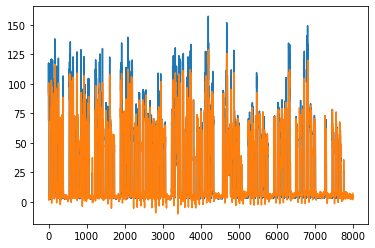

In [30]:
#sc=1
sc=(yMax-yMin)
yr_test=y_test.numpy()
yr_test=yr_test*sc

DNNpred=modelDNN(X_test.to(device)).cpu().detach().numpy()*sc
RNNpred=modelRNN(X_test.to(device)).cpu().detach().numpy()*sc
#plt.plot((yr_test-CNNpred)/yr_test)

plt.plot(yr_test)
plt.plot(RNNpred)

R2DNN=r2_score(yr_test,DNNpred)
MSEDNN=mean_squared_error(yr_test,DNNpred)
MAEDNN=mean_absolute_error(yr_test,DNNpred)
RMSEDNN=np.sqrt(MSEDNN)
DNNCV=RMSEDNN/np.mean(yr_test)

R2RNN=r2_score(yr_test,RNNpred)
MSERNN=mean_squared_error(yr_test,RNNpred)
MAERNN=mean_absolute_error(yr_test,RNNpred)
RMSERNN=np.sqrt(MSERNN)
RNNCV=RMSERNN/np.mean(yr_test)
print('DNN:\n','R2',R2DNN,'\nRMSE',RMSEDNN,'\nMAE',MAEDNN,'\nCV',DNNCV)
print('RNN:\n','R2',R2RNN,'\nRMSE',RMSERNN,'\nMAE',MAERNN,'\nCV',RNNCV)

In [16]:
DNNCV

3.5674925